In [59]:
import torch

from transformers import AutoModelForCausalLM, AutoTokenizer

import torch.nn.functional as F
from pathlib import Path
import json


In [3]:
model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1", 
                                        #   torch_dtype=torch.float16,
                                        #   device_map={"": 0}
                                        )
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")


Loading checkpoint shards: 100%|██████████| 2/2 [00:37<00:00, 18.74s/it]


In [135]:
model_gpt = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")

In [101]:
#not needed
def compute_token_probabilities(model, tokenizer, text):
    input_ids = tokenizer.encode(text, return_tensors='pt').to(model.device)
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits

    probs = F.softmax(logits, dim=-1)
    input_ids_onehot = F.one_hot(input_ids, num_classes=probs.shape[-1]).to(model.device)

    real_token_probs = probs[:,:-1] * input_ids_onehot[:,1:]
    real_token_probs = real_token_probs.sum(dim=2).squeeze()

    return real_token_probs

def compute_text_entropy_wrong(model, tokenizer, text):
    probs = compute_token_probabilities(model, tokenizer, text)
    entropy = - torch.sum(probs * torch.log(probs))
    return entropy / probs.size(0)

In [104]:
def compute_token_entropies(model, tokenizer, text):
    input_ids = tokenizer.encode(text, return_tensors='pt').to(model.device)
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits

    probs = F.softmax(logits, dim=-1)
    entropies = -(probs * torch.log(probs)).sum(dim=-1)

    return entropies

In [103]:
def read_text(path):
    with open(path, "r") as f:
        text = f.read()
    return text

In [70]:
data_path = Path("data")

In [147]:
loaded_texts = []

# Path to the JSON file
json_path = data_path / 'all_texts.json'

with open(json_path, 'r') as f:
    loaded_texts = json.load(f)



In [148]:
entropies = []
for text_entry in loaded_texts:
    text = text_entry['text_content']
    entropies.append(compute_token_entropies(model, tokenizer, text))


In [149]:
for i, text_entry in enumerate(loaded_texts):
    entropy = entropies[i]
    print(f"{text_entry['description'] :28} entropy: {entropy.mean().item() :.4f}")

BBC news article             entropy: 2.3201
new Rolling Stones song      entropy: 1.8015
Paint It Black               entropy: 0.4853
Yesterday                    entropy: 0.4817
Random from a bigram         entropy: 6.4820
Sample from Elon Musk bio    entropy: 1.9889
AAAAAAA                      entropy: 0.9506


In [116]:
import matplotlib.pyplot as plt 

In [141]:
np.log(tokenizer.vocab_size), np.log(tokenizer_gpt.vocab_size)

(10.373491181781864, 10.82490511970208)

In [142]:
np.log(2)

0.6931471805599453

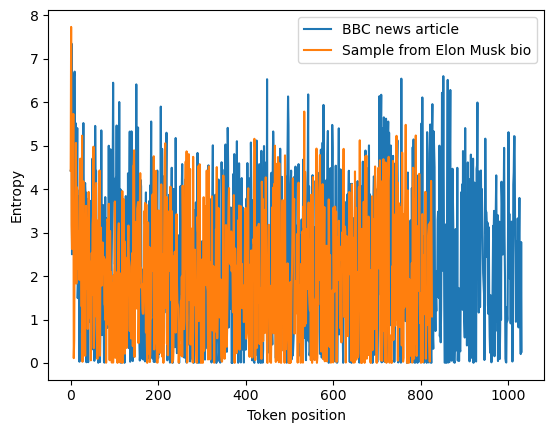

In [134]:
plt.plot(entropies[0].cpu().numpy()[0], label="BBC news article")
plt.plot(entropies[5].cpu().numpy()[0], label="Sample from Elon Musk bio")
plt.legend()
plt.xlabel("Token position")
plt.ylabel("Entropy")
plt.show()

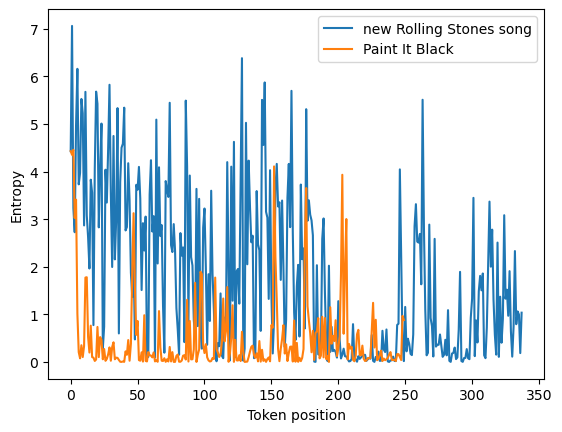

In [131]:
plt.plot(entropies[1].cpu().numpy()[0], label="new Rolling Stones song")
plt.plot(entropies[2].cpu().numpy()[0], label="Paint It Black")
plt.legend()
plt.xlabel("Token position")
plt.ylabel("Entropy")
plt.show()

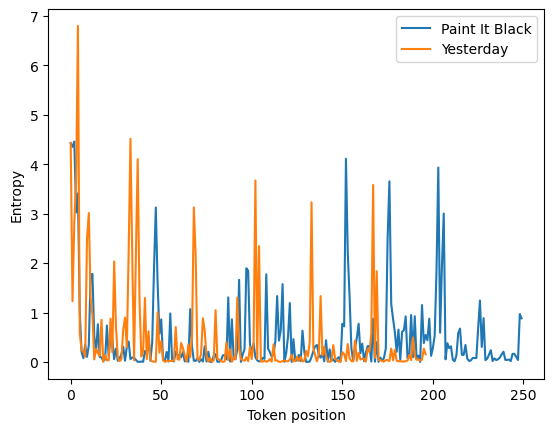

In [130]:
plt.plot(entropies[2].cpu().numpy()[0], label="Paint It Black")
plt.plot(entropies[3].cpu().numpy()[0], label="Yesterday")
plt.legend()
plt.xlabel("Token position")
plt.ylabel("Entropy")
plt.show()



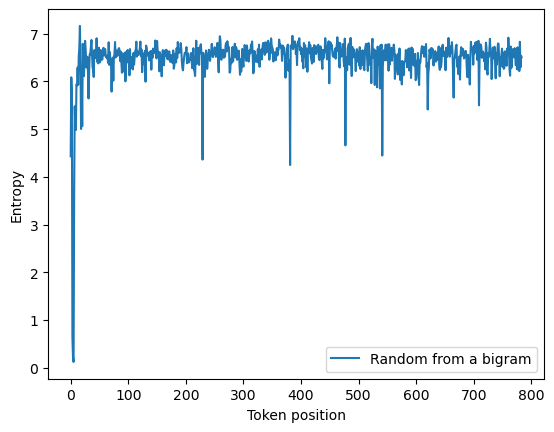

In [132]:
plt.plot(entropies[4].cpu().numpy()[0], label="Random from a bigram")
plt.legend()
plt.xlabel("Token position")
plt.ylabel("Entropy")
plt.show()


In [150]:
entropies_gpt = []
for text_entry in loaded_texts:
    text = text_entry['text_content']
    entropies_gpt.append(compute_token_entropies(model_gpt, tokenizer_gpt, text))

In [151]:
for i, text_entry in enumerate(loaded_texts):
    entropy = entropies_gpt[i]
    print(f"{text_entry['description'] :28} entropy: {entropy.mean().item() :.4f}")

BBC news article             entropy: 4.1336
new Rolling Stones song      entropy: 2.5249
Paint It Black               entropy: 3.0422
Yesterday                    entropy: 2.2080
Random from a bigram         entropy: 6.9146
Sample from Elon Musk bio    entropy: 3.2073
AAAAAAA                      entropy: 1.0517
